# Initialisation

/!\ FIRST THING TO DO :

EXECUTION --> MODIFIER LE TYPE D'EXECUTION --> GPU (Accélérateur matériel) 

FICHIER --> ENREGISTRER UNE COPIE DANS DRIVE

In [1]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

Verify GPU usage. You should see 

```
Number of GPUs available : 1
Only GPU number 0 used
```

In [2]:
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.6.0
Number of GPUs available : 1
Only GPU number 0 used


In [3]:
import numpy as np
import matplotlib.pyplot as plt  

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

### Intro

In this project, the goal is to create a set of NN-based transmitter and receiver that beats a conventional QAM system. 

The performance metric is the rate of the transmission. The rate of a transmission is the maximum number of bits that could be sent through the transmitter-receiver if perfect channel coding was used (the bits are coded/decoded before/after the transmissions). In this project, we won't use channel coding, so remember that the rate is a good indication of the performance of a system.

The questions should be answered in the report. Please contact me when you think you have the answer so that I can follow your progress :)

The goal is to finish section 1 and 2. Section 3 is optional. 

### Usefull functions
You do not have to use them all!

- https://www.tensorflow.org/api_docs/python/tf/cast?hl=fr --> tensorflow operations can only be carried out on tensors that have the same type (int8, float32, complex64...)
- https://www.tensorflow.org/api_docs/python/tf/shape
- https://www.tensorflow.org/api_docs/python/tf/size?hl=fr
- https://www.tensorflow.org/api_docs/python/tf/reshape
- https://www.tensorflow.org/api_docs/python/tf/concat
- https://www.tensorflow.org/api_docs/python/tf/one_hot
- https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
- https://www.tensorflow.org/api_docs/python/tf/math/reduce_sum
- https://www.tensorflow.org/api_docs/python/tf/expand_dims
- https://www.tensorflow.org/api_docs/python/tf/linalg/matmul
- https://www.tensorflow.org/api_docs/python/tf/size?hl=fr

### Usefull jupyter notebook commands

- `Ctrl + Enter` : Execute command
- `Shift + Enter` : Execute command and go to next cell
-  `dd` : Delete cell
- 'b' : Create new cell below
- 'a' : Create new cell above
- The little arrow next to titles : group cells from the specific section

# Predefined functions

## Not intersting

Do not look at this code, it is boring

In [4]:
def visualize (model, SNRs_db):
    K = model.K
    msg = np.arange(2**K)
    res = []
    for i in range(2**K):
        temp=msg[i]
        res_ = []
        for j in 2**np.linspace(K-1, 0, K):
            if temp - j >= 0 :
                res_.append(1)
                temp -= j
            else:
                res_.append(0)
        res.append(res_)
    bits = np.array(res, dtype=np.float32) 
    
    fig, axes = plt.subplots(1, len(SNRs_db), figsize=(len(SNRs_db)*7, 6))
    if len(SNRs_db) == 1 :
        axes = np.array([axes])
    for i in range(len(SNRs_db)):
                   
        llrs = model(bits, tf.ones(shape=(tf.shape(bits)[0], 1))*SNRs_db[i])
        x = model.x
        if tf.size(tf.shape(x)) == 1 :
            x = x[:, tf.newaxis]
                   
        axes[i].set_title('SNR_db = '+str(SNRs_db[i]))
        for j in range(2**K):
            axes[i].scatter(np.real(x[j, 0]), np.imag(x[j, 0]))
            axes[i].text(np.real(x[j, 0])+0.02, np.imag(x[j, 0])+0.02, np.binary_repr(j, width=K), fontsize=8)
            axes[i].set_xlim([-1.65, 1.65])
            axes[i].set_ylim([-1.65, 1.65])

In [5]:
def visualize_channel_uses (model, SNR_db):
    K = model.K
    msg = np.arange(2**K)
    res = []
    for i in range(2**K):
        temp=msg[i]
        res_ = []
        for j in 2**np.linspace(K-1, 0, K):
            if temp - j >= 0 :
                res_.append(1)
                temp -= j
            else:
                res_.append(0)
        res.append(res_)
    bits = np.array(res, dtype=np.float32) 
    llrs = model(bits, tf.ones(shape=(tf.shape(bits)[0], 1))*SNR_db)
    
    x = model.x
    
    if tf.size(tf.shape(x)) == 1 :
        x = x[:, tf.newaxis]
    
    fig, axes = plt.subplots(1, model.Nc, figsize=(model.Nc*7, 6))
    if model.Nc == 1 :
        axes = np.array([axes])
    for i in range(model.Nc):
        if model.Nc != 1 :
            axes[i].set_title('Channel use n° '+str(i+1))
        for j in range(2**K):
            axes[i].scatter(np.real(x[j, i]), np.imag(x[j, i]))
            axes[i].text(np.real(x[j, i])+.02, np.imag(x[j, i])+.02, np.binary_repr(j, width=K), fontsize=8)
            axes[i].set_xlim([-1.65, 1.65])
            axes[i].set_ylim([-1.65, 1.65])

In [6]:
def table_gray(K):
        def genCode(n):
                if n == 0:
                    return ['']

                code1 = genCode(n-1)
                code2 = []
                for codeWord in code1:
                    code2 = [codeWord] + code2

                for i in range(len(code1)):
                    code1[i] += '0'
                for i in range(len(code2)):
                    code2[i] += '1'
                return code1 + code2  

        k = K // 2 # bits per dimension
        syms = 2**k
        m = syms**2
        # gray labeling
        gray_labeling = []
        for i in range(2**k):
            gray_labeling.append(np.array([int(e) for e in  genCode(k)[i]]))
        gray_labeling = np.array(gray_labeling)

        encoding_table_256_qam = gray_labeling[:,::-1]

        encoding_table_256_qam = np.hstack( [np.kron(encoding_table_256_qam,np.ones((syms,1))), np.tile(encoding_table_256_qam,(syms,1)) ])

        natural_number = np.sum(2**np.arange(2*k)[::-1] * encoding_table_256_qam,axis=1)
        table_gray = np.zeros((m,m))
        for bvec in range(m):
            table_gray[bvec,np.where(natural_number==bvec)[0]] =1

        return table_gray

In [7]:
def qam_const(K):
    M = 2**K
    size = int(np.sqrt(M))
    a = np.arange(size)
    b = a - np.mean(a)
    C=[]
    for i in range(size):
        for j in range(size):
            C.append(b[j]-1j*b[i])
    C = C/np.sqrt(np.mean(np.square(np.abs(C))))
    return C.astype(np.complex64)


In [8]:
def evaluate_rate(model, SNRs_eval, DS_size=10000):
    
    print('K = '+str(model.K))
    
    DS_bits, DS_SNRs = gen_DS(DS_size, model.K, 1., 1.)
    TF_DS_test = tf.data.Dataset.from_tensor_slices((DS_bits, DS_SNRs)).shuffle(DS_size).batch(1000)
    
    print("SNR (dB) = ", end='')
    rates = []
    for snr_i in SNRs_eval :

        rates_temp = []
        for step, (bits, SNRs) in enumerate(TF_DS_test):
            pb_eq_1 = model(bits, SNRs*snr_i)
            bits_pred = tf.sign(pb_eq_1-0.5)/2.+0.5
            err_1 = tf.abs(bits - bits_pred)
            err_2 = tf.abs(bits_pred - bits)
            err_3 = tf.reduce_sum(tf.nn.relu(err_1 - err_2)) * tf.reduce_mean(tf.nn.tanh(err_2 - err_1))
            err_4 =  tf.reduce_mean(tf.keras.losses.binary_crossentropy(bits, pb_eq_1)) * (tf.reduce_max(bits) + err_3)
            rates_temp.append(model.K-err_4.numpy())
        rates.append(np.mean(rates_temp))
        print(str(snr_i)+', ', end='')
    print('')
    return rates

## Could be interesting

This could be interesting

In [9]:
def gen_DS(DS_size, K, SNR_db_low, SNR_db_high):
    """Returns a dataset of dimension [epochs, Bs, K]"""
        
    DS_bits = tf.random.uniform(shape=[DS_size, K], minval=0, maxval=2, dtype=tf.int32)
    DS_SNRs = tf.random.uniform(shape=[DS_size, 1], minval=SNR_db_low, maxval=SNR_db_high)
    return tf.cast(DS_bits, tf.float32), DS_SNRs

# Predefined classes

## Not interesting

Boring or "complex" stuff

In [10]:
class Mapper(Layer):
    """
    Maps vector of K bits to a complex symbol
    Inputs :
    - K, the nber of bits/ch_uses
    """
    def __init__(self, K, Nc, rayleigh):
        super().__init__()     
        
        self.K = K
        self.Nc = Nc
        self.rayleigh = rayleigh
        
        if self.rayleigh == True :
            self.Nc -= 1
            if self.Nc < 1:
                print('/!\ with Rayleigh fading, Nc must be higher than one (Nc >= 2)')
                raise Exception()
        self.bin_conv = tf.convert_to_tensor(np.flip([np.power(2, i) for i in range(self.K)]), dtype=tf.float32)
        
    def call(self, bits, GM, QAM_const):
        """
        Inputs:
        - bits = [Bs, K] 
        - GM, the Gray Mapping
        - C = [M], the corresponding constallation
        
        Outputs:
        - x = [Bs, Nc] 
        """
        self.bits = bits
        self.bits_rshp = tf.reshape(bits, [-1, tf.shape(bits)[-1]])
        
        self.C_batch = tf.tile(tf.expand_dims(QAM_const, axis=0), [tf.shape(bits)[0], 1])
        
        self.s_dec = tf.cast(tf.reduce_sum(self.bits_rshp*self.bin_conv[tf.newaxis, :], axis=1), tf.int32) # [BS]
        self.s_idx = tf.gather(GM, self.s_dec, axis=0)
        self.s_idx = tf.argmax(self.s_idx, axis=1, output_type=tf.int32)
        
        self.s_oh = tf.one_hot(self.s_idx, depth=tf.pow(2, self.K))
        self.C_exp = tf.reshape(tf.tile(self.C_batch[:, tf.newaxis, :], [1, 1, 1]), [-1, tf.pow(2, self.K)])[:, :, tf.newaxis]
        
        # Mapping symbols to complex points
        self.x_rshp = tf.squeeze(tf.matmul(tf.cast(self.s_oh[:, tf.newaxis, :], tf.complex64), self.C_exp))
        self.x = tf.tile(tf.reshape(self.x_rshp, [tf.shape(bits)[0], 1])[:, tf.newaxis, :], [1, self.Nc, 1])[:, :, 0]
        
        if self.rayleigh == True:
            self.x = tf.concat([self.x, tf.ones([tf.shape(self.x)[0], 1], dtype=tf.complex64)], axis=1)
            
        return self.x

In [11]:
class Channel(Layer):

    def __init__(self, Nc=1, rayleigh=False, **kwargs):
        super(Channel, self).__init__(**kwargs)
        
        self.Nc = Nc
        self.rayleigh = rayleigh
        
    def call(self, x, SNR_db):
        
        if tf.reduce_mean(tf.square(tf.abs(x)))>2.5:
            tf.print('Watch out! You mean power should be one, but is actually ' + str(tf.reduce_mean(tf.square(tf.abs(x))).numpy()))
            raise Exception ('Stop due to wrong average symbol power')
        
        dims_1 = False
        if tf.size(tf.shape(x)) == 1 :
            x = x[tf.newaxis]
            dims_1 = True
            
        if self.rayleigh == False:
            noise_std = tf.sqrt( 1 / tf.pow(10., SNR_db/10.0))
            noise_r = tf.random.normal(shape = [tf.shape(x)[0], self.Nc], stddev = 1) * noise_std/tf.sqrt(2.)
            noise_i = tf.random.normal(shape = [tf.shape(x)[0], self.Nc], stddev = 1) * noise_std/tf.sqrt(2.)
            self.noise_cplx = tf.complex(noise_r, noise_i)
        
            self.y = x + self.noise_cplx
        
        else:
            rayleigh_real = tf.random.normal(shape = [tf.shape(x)[0]], stddev = 1./tf.sqrt(2.))
            rayleigh_imag = tf.random.normal(shape = [tf.shape(x)[0]], stddev = 1./tf.sqrt(2.))
            self.h = tf.tile(tf.complex(rayleigh_real, rayleigh_imag)[:, tf.newaxis], [1, self.Nc])

            noise_std = tf.sqrt( 1 / tf.pow(10., SNR_db/10.0))
            noise_r = tf.random.normal(shape = [tf.shape(x)[0], self.Nc], stddev = 1) * noise_std/tf.sqrt(2.)
            noise_i = tf.random.normal(shape = [tf.shape(x)[0], self.Nc], stddev = 1) * noise_std/tf.sqrt(2.)
            self.noise_cplx = tf.complex(noise_r, noise_i)

            self.y = self.h*x + self.noise_cplx
        
        if dims_1 == True :
            self.y = self.y[:, 0]
            
        return self.y

In [12]:
class Demapper(Layer):

    def __init__(self, K, GM, rayleigh, **kwargs):
        super().__init__(**kwargs)
        
        self.K = K
        self.const_size = 2**K
        self.rayleigh = rayleigh
        
        self.bits2symb = np.argmax(GM, axis=1)
        bit_list = np.arange(self.const_size)
        bit_list = [[int(j) for j in list(np.binary_repr(i, width=self.K))] for i in bit_list]
        self.bits_nat = np.array(bit_list)

        self.ind_all = np.arange(self.const_size, dtype=np.int64)

        self.B = []
        for i in range(self.K):
            self.B.append([None, None])
            # 0
            a = np.where(self.bits_nat[:,i] == 0)[0]
            self.B[i][0] = np.take(self.bits2symb, a)
            # 1
            a = np.where(self.bits_nat[:,i] == 1)[0]
            self.B[i][1] = np.take(self.bits2symb, a)
    
    
    def awgn_cde(self, snr_db, y, s, C):
        mu = tf.gather(C, s, axis=1)
        snr = tf.pow(tf.cast(10.0, tf.float32), snr_db/10.0)
        v = 1./(snr)
        z = -tf.reduce_sum(tf.square(y - mu), axis=2)/v
        
        return z
    
    def call(self, y_cplx, SNR_db, QAM_const):
        """
        AWGN demapper for SISO links
        
        Inputs : y_cplx = [Bs, Nc], snr_db = [1], C = [M]
        Outputs : LLRs = [Bs, K]
        """
        if self.rayleigh==True:
            y_cplx_eq = y_cplx[:, :-1] / y_cplx[:, -1:]
            y_cplx_mean = tf.reduce_mean(y_cplx_eq, axis=1, keepdims=True)
        else :
            y_cplx_mean = tf.reduce_mean(y_cplx, axis=1, keepdims=True)
            
        SNR_db_batch = SNR_db #tf.ones([tf.shape(y_cplx_mean)[0], 1]) * SNR_db
        C_batch = tf.tile(tf.expand_dims(QAM_const, axis=0), [tf.shape(y_cplx_mean)[0], 1])
        
        C_r_i = tf.stack([tf.math.real(C_batch), tf.math.imag(C_batch)], axis=2)
        y = tf.stack([tf.math.real(y_cplx_mean), tf.math.imag(y_cplx_mean)], axis=2) 
        
        pyb_0 = []
        pyb_1 = []
        y = tf.tile(y, [1, self.const_size//2, 1])
        y_2 = tf.tile(y, [1, 2, 1])
        p = tf.constant(self.ind_all, tf.int32)
        z_all = self.awgn_cde(SNR_db_batch, y_2, p, C_r_i)
        for i in range(self.K):
            # 0
            p = tf.constant(self.B[i][0], tf.int32)
            z = tf.gather(z_all, p, axis=1)
            z = tf.math.reduce_logsumexp(z, axis=1)
            pyb_0.append(z)
            # 1
            p = tf.constant(self.B[i][1], tf.int32)
            z = tf.gather(z_all, p, axis=1)
            z = tf.math.reduce_logsumexp(z, axis=1)
            pyb_1.append(z)
        pyb_0 = tf.stack(pyb_0, axis=1)
        pyb_1 = tf.stack(pyb_1, axis=1)
        llr = pyb_1 - pyb_0
        
        return llr

## Could be interesting

You might want to look at it

In [13]:
class Model_QAM(Model) :
    def __init__(self, K, Nc=1, rayleigh=False):
        super().__init__()
        
        self.K = K
        self.Nc = Nc 
        self.QAM_const = tf.constant(qam_const(K))
        self.GM = tf.constant(table_gray(K), tf.float32)

        self.mapper = Mapper(self.K, self.Nc, rayleigh)
        self.channel = Channel(self.Nc, rayleigh)
        self.demapper = Demapper(self.K, self.GM, rayleigh)

    #@tf.function
    def call(self, bits, SNR_db):
        
        self.bits = tf.cast(bits, tf.float32)
        
        self.x = self.mapper(bits, self.GM, self.QAM_const)
            
        self.y = self.channel(self.x, SNR_db)

        self.llrs = self.demapper(self.y, SNR_db, self.QAM_const)
        
        self.pb_eq_1 = tf.nn.sigmoid(self.llrs)
        
        return self.pb_eq_1

# Baseline (QAM) system

<img src="https://github.com/mgoutay/ml_course/blob/master/Images/standard_system.png?raw=true" alt="Drawing" style="width: 700px;"/>

### QAM transmission

Let's start by defining the baseline that we want to beat : a 64-QAM transmitter/receiver

The number of bits represented by one complex symbol is denoted $K$

Using a 64-QAM transmitter means that we use one complex symbol to transmit 6 bits ($K=6$)

- choosing $K=2$ means that QPSK (= 4-QAM) is used
- choosing $K=4$ means that 16-QAM is used
- etc..

### Notations

(scalars are denoted by lower-case letters, vectors by bold lower-case letters)

The bits that we want to send over the channel are denoted $\mathbf{b}\in\{0, 1\}^{K}$. It is a vector of bits (0, 1) of size $K$.

The corresponding complex symbol sent by the transmitter is denoted $x\in\mathbb{C}$, and the symbol received by the receiver is denoted $y\in\mathbb{C}$

Finally, the receiver outputs probabilities $\mathbf{p}\in\mathbb{R}^K$. Each entry $p_i$ of $\mathbf{p}$ correspond to the probability that the $i^{\text{th}}$ bit equals one, so we have $0 \leq p_i \leq 1$

### Channel model

We consider a Additive White Gaussian Noise (AWGN) channel, where we have: 
$$y = x + n$$
$n$ being complex gaussian noise with variance $\sigma^2$ : $n \sim \mathcal{C}\mathcal{N}(0, \sigma^2) $, meaning that the variance of both the real and imaginary part is $\frac{\sigma^2}{2}$.

It is assumed that $\mathbb{E}[|x|^2] =1$, i.e., the average power per symbol is one.

The Signal to Noise Ratio (SNR) of the transmission is defined as $\text{SNR} = \frac{\mathbb{E}[|x|^2]}{\sigma^2} = \frac{1}{\sigma^2} $. It is common practice to represent the SNR in decibel : $\text{SNR}_{\text{dB}} = 10 \text{log}_{10} (\text{SNR})$

In [14]:
K=6
DS_size=10000 #Size of the Dataset to generate

DS_bits, DS_SNRs_db = gen_DS(DS_size, K, SNR_db_low=-5, SNR_db_high=30)

### Dataset

The datasets are generated by the `gen_DS` function, which returns a dataset composed of random bits of dimension [DS_size, K] and random SNRs of dimension [DS_size, 1] in dB. 

In [15]:
print(DS_bits.shape)
print(DS_SNRs_db.shape)

(10000, 6)
(10000, 1)


In [16]:
print(DS_bits[:2]) #Display only the first two entries in the dataset
print(DS_SNRs_db[:2]) #Display only the first two entries in the dataset

tf.Tensor(
[[1. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]], shape=(2, 6), dtype=float32)
tf.Tensor(
[[20.470196]
 [10.62888 ]], shape=(2, 1), dtype=float32)


We can now initialize our baseline model, and make a simple forward pass through it. The output of the model is the estimated probabilities that the received bits are ones. Let's try with the first two sample of our dataset :

In [17]:
# Initialize the baseline
baseline = Model_QAM(K)

# Define a very small batch just just to visualize the output
batch_bits = DS_bits[:2]
batch_SNRs = DS_SNRs_db[:2]

# Print the sent bits
print(batch_bits)

# Compute probabilities that the bits equals to one
prob_eq_1 = baseline(batch_bits, batch_SNRs)

# Print the symbols that were sent
print(baseline.x)

# Print the predicted probabilities
print(prob_eq_1)

tf.Tensor(
[[1. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]], shape=(2, 6), dtype=float32)
tf.Tensor(
[[ 1.0801234-1.0801234j ]
 [-1.0801234-0.77151674j]], shape=(2, 1), dtype=complex64)
tf.Tensor(
[[1.0000000e+00 4.1791446e-16 8.3070260e-04 1.0000000e+00 1.4673218e-21
  1.5571970e-06]
 [9.9997604e-01 1.9073105e-01 7.8048491e-01 1.5172577e-07 2.4967281e-02
  3.9336425e-01]], shape=(2, 6), dtype=float32)


We can vizualize the symbol sent at different SNRs (and the associated bits) using the `visualize()` function : 

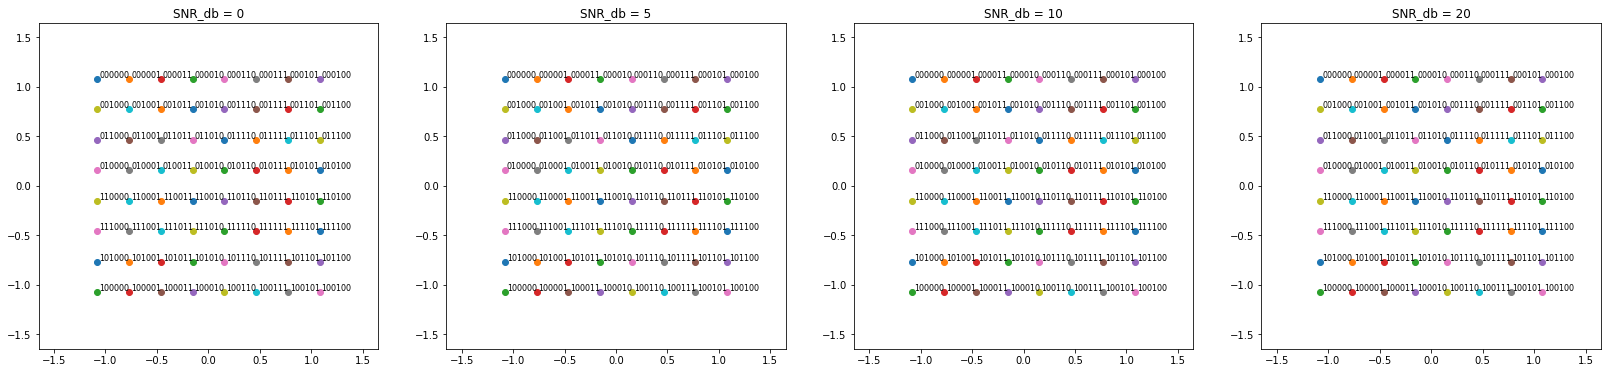

In [18]:
visualize(baseline, SNRs_db=[0, 5, 10, 20])

Can you see something special about the way the symbols are attanged?

Finally, the rate of a transmission is the maximum number of bits that could be sent through the transmitter-receiver if perfect channel coding was used (the bits are coded/decoded before/after the transmissions). In this project, we won't use channel coding, so remember that the rate is a good indication of the performance of a system. The computation of the rate is a bit complex so do not try to undersand it ;)

We can evaluate the rate of the transmission at different SNRs using the `evaluate_rate()` function:

K = 6
SNR (dB) = 0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 


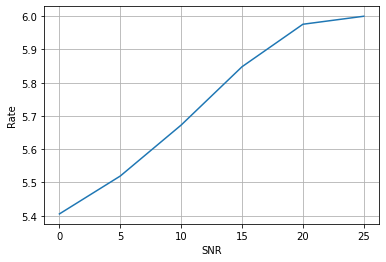

In [19]:
SNRs_eval = np.linspace(0, 25, 6)
rates_baseline = evaluate_rate(baseline, SNRs_eval)

plt.plot(SNRs_eval, rates_baseline)
plt.xlabel('SNR')
plt.ylabel('Rate')
plt.grid()

These are the rates we want to beat! 

# 1- Get your hands dirty

<img src="https://github.com/mgoutay/ml_course/blob/master/Images/NN-based_system.png?raw=true" alt="Drawing" style="width: 700px;"/>

In this first section, the goal is to create your first autoencoder. To make trainings faster, we set $K = 4$ here. Do not try to beat the baseline, as it might be hard for $K<6$

The main objectives are to :
- Define a loss function
- Create the NN-based transmitter and receiver 
- To normalize the output so that the average power per symbol is one
- Create a training loop
- Train, evaluate, and compare your system to the baseline

You need to make sure that your average power per symbol is one !
You can compute your average energy by computing `tf.reduce_mean(tf.square(tf.abs(x)))` once you have performed at least one forward path (so that self.x  contains some values)

$$\mathbb{E}[|x|^2] \approx \frac{1}{B_s} \sum_{i=1}^{B_s} |x|^2 $$

How can you make sure that $\frac{1}{B_s} \sum_{i=1}^{B_s} |x|^2 = 1$ ?

**On divise nos symboles par la racine carrée de la moyenne des symboles au carré :**

**`self.x /= tf.cast(tf.sqrt(tf.reduce_mean(tf.square(tf.abs(self.x)))), tf.complex64)`**

### 1.0 - Import the layer(s) you need

In [20]:
### Import the layer(s) you need
from tensorflow.keras.layers import Dense

**A priori ici on aura besoin que des couches denses, pas de couches Softmax car notre problème n'est pas de la classification**

### 1.1 -  Define the model

In [21]:
# This is your autoencoder model, comprising the transmitter, channel, and receiver
class Autoencoder(Model):

    def __init__(self, K, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        self.K = K
        
        self.tx_layer_1 = Dense(256, activation='relu') ### Define transmitter layers
        self.tx_layer_2 = Dense(256, activation='relu') ### Define transmitter layers
        self.tx_layer_3 = Dense(256, activation='relu') ### Define transmitter layers
        self.tx_layer_4 = Dense(2) ### Define transmitter layers
        
        self.channel = Channel() 
        
        self.rx_layer_1 = Dense(256, activation='relu') ### Define receiver layers
        self.rx_layer_2 = Dense(256, activation='relu') ### Define receiver layers
        self.rx_layer_3 = Dense(256, activation='relu') ### Define receiver layers
        self.rx_layer_4 = Dense(self.K, activation='sigmoid') ### Define receiver layers
    
    def call(self, bits, SNR_db):
        
        ### Emitter
        self.x = tf.concat([SNR_db, bits], axis=1)
        self.x = self.tx_layer_1(self.x)
        self.x = self.tx_layer_2(self.x)
        self.x = self.tx_layer_3(self.x)
        self.x = self.tx_layer_4(self.x)
        
        ### Normalization & Channel
        self.x = tf.complex(self.x[:,:1], self.x[:,1:])
        self.x /= tf.cast(tf.sqrt(tf.reduce_mean(tf.square(tf.abs(self.x)))), tf.complex64)
        self.y = self.channel(self.x, SNR_db)
        self.y = tf.concat([tf.math.real(self.y), tf.math.imag(self.y)], axis=1)

        ### Receiver
        self.y = tf.concat([SNR_db, self.y], axis=1)
        self.y = self.rx_layer_1(self.y)
        self.y = self.rx_layer_2(self.y)
        self.y = self.rx_layer_3(self.y)
        self.pb = self.rx_layer_4(self.y)
        
        return self.pb
  

### 1.2 -  Instantiate the model, the loss, and the optimizer

In [22]:
K = 4

autoencoder = Autoencoder(K) # Instantiate an autoencoder
baseline = Model_QAM(K) # Instantiate a baseline with the same K for comparison

#Initialize optimizer and loss function
optimizer = tf.keras.optimizers.Adam() # Instantiate an optimizer
loss_func = tf.keras.losses.BinaryCrossentropy() # Pick a loss function that makes sense for this problem, do not try to understand how the rate is computed! If you choose a good loss funciton, the rate of the transmission will be maximized

What loss function did you use and why?

### 1.3 - generate and create optimized Tensorflow datasets

In [23]:
DS_size_train = 100000
DS_size_test = 1000

batch_size = 1024
DS_bits, DS_SNRs_db = gen_DS(DS_size_train+DS_size_test, K, SNR_db_low=-5, SNR_db_high=30)
TF_DS_train = tf.data.Dataset.from_tensor_slices((DS_bits[:DS_size_train], DS_SNRs_db[:DS_size_train])).shuffle(10000).batch(batch_size)
TF_DS_test = tf.data.Dataset.from_tensor_slices((DS_bits[DS_size_train:], DS_SNRs_db[DS_size_train:])).batch(batch_size)

### 1.4 - Train the model

In [24]:
### Training loop 
nb_epoch = 50

print('Loss after each epoch:')

for epoch in range(nb_epoch):
    
    # Iterate over the batches of the dataset.
    for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_train):
        
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = autoencoder(DS_bits, DS_SNRs_db)

            # Loss value for this batch.
            loss_value = loss_func(y_true=DS_bits, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
    
    #Test the model on the test datasets
    test_loss = 0.
    for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_test):
        probas = autoencoder(DS_bits, DS_SNRs_db)
        test_loss += loss_func(y_true=DS_bits, y_pred=probas)
    print((test_loss/(step+1)).numpy(), end=', ')
print('Done')

Loss after each epoch:
0.41206706, 0.3654246, 0.30677828, 0.23233454, 0.20310767, 0.20908871, 0.18557094, 0.23375294, 0.19743396, 0.18021853, 0.17834829, 0.4227119, 0.17959933, 0.16672806, 0.17075026, 0.17584628, 0.17361283, 0.17250356, 0.16101609, 0.17459418, 0.16888012, 0.17078154, 0.16495048, 0.17730762, 0.16889037, 0.15867063, 0.1617259, 0.16130808, 0.15889773, 0.16491592, 0.16011852, 0.16441166, 0.1706985, 0.1600885, 0.17322598, 0.16570535, 0.16410398, 0.16896902, 0.16836168, 0.15736404, 0.15649492, 0.16310932, 0.16150838, 0.15804286, 0.16121979, 0.16045971, 0.16511266, 0.16328083, 0.15208627, 0.16180769, Done


### 1.5 - Evaluate the model

In Section 1, the goal is to have a model that works. You can evaluate the model with the `evaluate_rate()` function, but do not try to beat the baseline.

K = 4
SNR (dB) = 0.0, 5.0, 10.0, 15.0, 20.0, 
K = 4
SNR (dB) = 0.0, 5.0, 10.0, 15.0, 20.0, 


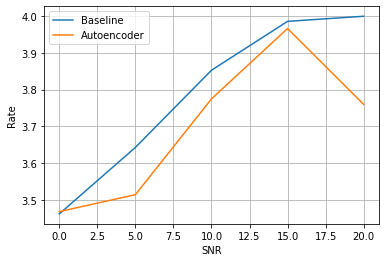

In [25]:
# Define the SNRs (dB) at which we want to evaluate the models
SNRs_eval = np.linspace(0, 20, 5)

# Evaluate the models
rate_autoencoder = evaluate_rate(autoencoder, SNRs_eval)
rate_baseline = evaluate_rate(baseline, SNRs_eval) # For comparison

#plot the result
plt.plot(SNRs_eval, rate_baseline, label='Baseline')
plt.plot(SNRs_eval, rate_autoencoder, label='Autoencoder')
plt.xlabel('SNR')
plt.ylabel('Rate')
plt.legend()
plt.grid()

We can vizualize the learned constellations at different SNRs:

What do you see (two things should be noticed)?

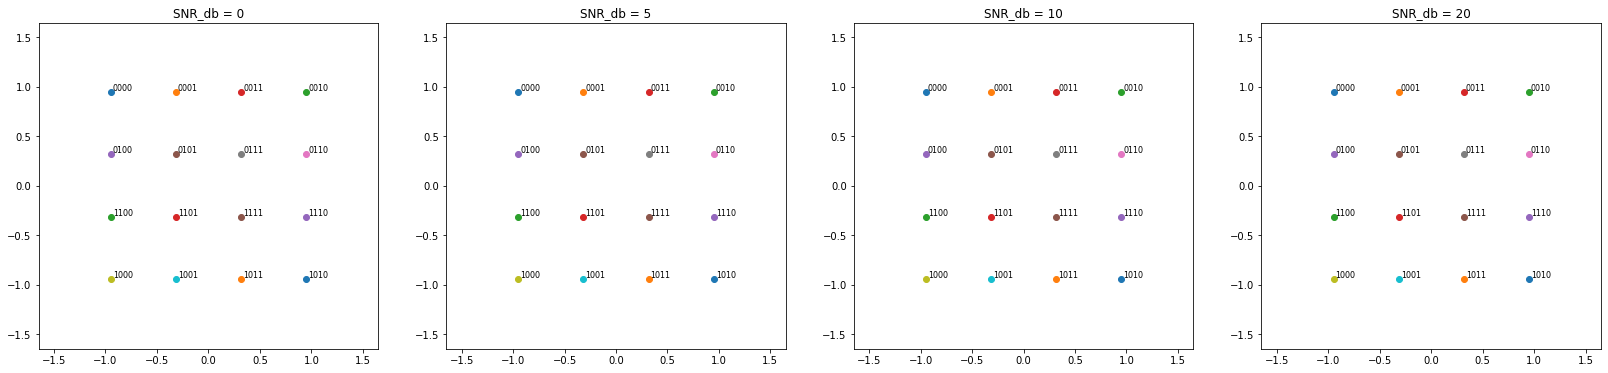

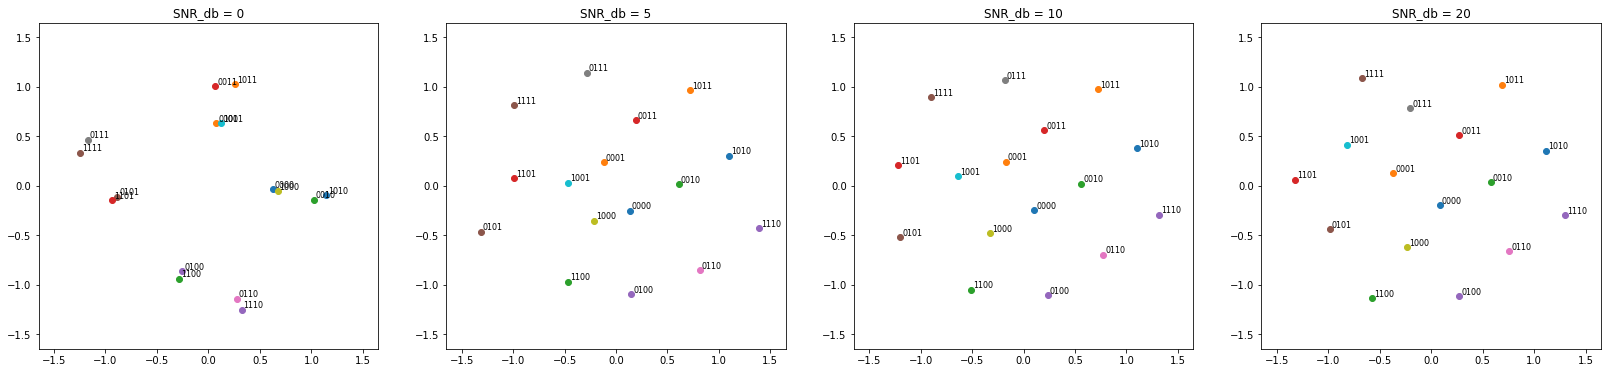

In [26]:
visualize(baseline, SNRs_db=[0, 5, 10, 20]) #Visualize the symbols generated by the conventional QAM system
visualize(autoencoder, SNRs_db=[0, 5, 10, 20]) #Visualize the symbols generated by the autoencoder

Send three batches of random bits and plot the sent symbols for a fixed SNR of 10dB:

What do you see ?

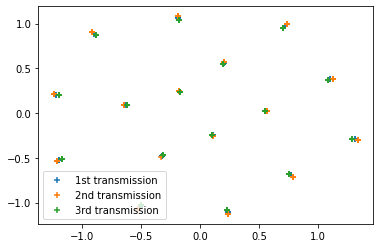

In [27]:
SNRs =  tf.ones((100, 1))*10.

rdm_bits = tf.cast(tf.random.uniform([100, K], 0, 2, dtype=tf.int32), tf.float32)
pb = autoencoder(rdm_bits, SNRs)
plt.scatter(np.real(autoencoder.x), np.imag(autoencoder.x), marker='+', label='1st transmission')

rdm_bits = tf.cast(tf.random.uniform([100, K], 0, 2, dtype=tf.int32), tf.float32)
pb = autoencoder(rdm_bits, SNRs)
plt.scatter(np.real(autoencoder.x), np.imag(autoencoder.x), marker='+', label='2nd transmission')

rdm_bits = tf.cast(tf.random.uniform([100, K], 0, 2, dtype=tf.int32), tf.float32)
pb = autoencoder(rdm_bits, SNRs)
plt.scatter(np.real(autoencoder.x), np.imag(autoencoder.x), marker='+', label='3rd transmission')

plt.legend()

# 2. Generate a proper constellation

Here we want to solve the problem that we have spotted just above. Please call me before starting Section 2 so that I can make sure that you understand the problem.

The idea here is to use the transmitter to generate constellation vectors that depends on the SNR, instead of directly generating the symbols to send. For one entry in the batch (one SNR), this constellation vector contains all $2^K$ symbols that can be sent, so it is a complex vector of size $2^K$.

To generate the sent symbols, one can then:
- For each entries in the batch, convert the vector of bits to be send to their one-hot representation. For example, with $K=2$ : [00] = [1000], [10] = [0100], [01] = [0010], [11] = [0001] or something similar.  You might want to use `tf.pow()` and `tf.one_hot()`
- Multiply (element-wise) the one-hot representation of the bits to the corresponding constellation vector generated by the transmitter
- The resulting vector is of size $2^K$ but only one entry is non-zero. This can be simplified to a single complex number, for example using `tf.reduce_sum()` on the good axis

What is the benefit of using this technique?

### 2.1 Define the model

In [28]:
class Autoencoder2(Model):

    def __init__(self, K, **kwargs):
        super(Autoencoder2, self).__init__(**kwargs)
        
        self.K = K
        self.powtwo = tf.constant([float(tf.pow(2, i)) for i in range(self.K)])
        
        self.tx_layer_1 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_2 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_3 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_4 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_5 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_6 = Dense(2 * tf.pow(2, K)) ### Define transmitter layers
        
        self.channel = Channel() 
        
        self.rx_layer_1 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_2 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_3 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_4 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_5 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_6 = Dense(self.K, activation='sigmoid') ### Define receiver layers
    
    def call(self, bits, SNR_db):        
        ### Emitter
        self.x = SNR_db
        self.x = self.tx_layer_1(self.x)
        self.x = self.tx_layer_2(self.x)
        self.x = self.tx_layer_3(self.x)
        self.x = self.tx_layer_4(self.x)
        self.x = self.tx_layer_5(self.x)
        self.x = self.tx_layer_6(self.x)
        self.x = tf.complex(self.x[:,:(tf.pow(2,K))], self.x[:,(tf.pow(2,K)):])

        ### Normalization & Channel
        bit = tf.math.reduce_sum(bits * self.powtwo, 1)
        bit = tf.cast(bit, tf.int32)
        bit = tf.one_hot(bit, tf.pow(2, K))
        self.energy = tf.reduce_mean(tf.square(tf.abs(self.x)), axis=1, keepdims=True)
        self.x = self.x/tf.cast(tf.sqrt(self.energy),tf.complex64)
        self.x = tf.reduce_sum(tf.math.multiply(self.x, tf.cast(bit,tf.complex64)), axis=1, keepdims=True)
        self.y = self.channel(self.x, SNR_db)
        self.y = tf.concat([tf.math.real(self.y), tf.math.imag(self.y)], axis=1)
        
        ### Receiver
        self.y = tf.concat([SNR_db, self.y], axis=1)
        self.y = self.rx_layer_1(self.y)
        self.y = self.rx_layer_2(self.y)
        self.y = self.rx_layer_3(self.y)
        self.y = self.rx_layer_4(self.y)
        self.y = self.rx_layer_5(self.y)
        self.pb = self.rx_layer_6(self.y)
        
        return self.pb

You can start by setting $K=4$, but remember to use $K=6$ when you try to beat the baseline

### 2.2 -  Instantiate the model, the loss, and the optimizer

In [29]:
K = 6

# Instantiate an autoencoder
autoencoder2 = Autoencoder2(K)
baseline2 = Model_QAM(K)

#Initialize optimizer and loss function
optimizer = tf.keras.optimizers.Adam() # Optimizer
loss_func = tf.keras.losses.BinaryCrossentropy() # Loss function

### 2.3 - generate and create optimized Tensorflow datasets

In [30]:
DS_size_train = 100000
DS_size_test = 1000

batch_size = 1024
DS_bits, DS_SNRs_db = gen_DS(DS_size_train+DS_size_test, K, SNR_db_low=-5, SNR_db_high=30)
print('Dataset generated with K =', K)
TF_DS_train = tf.data.Dataset.from_tensor_slices((DS_bits[:DS_size_train], DS_SNRs_db[:DS_size_train])).shuffle(10000).batch(batch_size)
TF_DS_test = tf.data.Dataset.from_tensor_slices((DS_bits[DS_size_train:], DS_SNRs_db[DS_size_train:])).batch(batch_size)

Dataset generated with K = 6


### 2.4 - Train the model


In [31]:
### Training loop 
nb_epoch = 100

print('Loss after each epoch:')

for epoch in range(nb_epoch):
    
    # Iterate over the batches of the dataset.
    for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_train):
        
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = autoencoder2(DS_bits, DS_SNRs_db)

            # Loss value for this batch.
            loss_value = loss_func(y_true=DS_bits, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder2.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder2.trainable_weights))
    
    #Test the model on the test datasets
    test_loss = 0.
    for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_test):
        probas = autoencoder2(DS_bits, DS_SNRs_db)
        test_loss += loss_func(y_true=DS_bits, y_pred=probas)
    print((test_loss/(step+1)).numpy(), end=', ')
print('Done')

Loss after each epoch:
0.40371934, 0.32535067, 0.31211597, 0.2979918, 0.33699417, 0.29727352, 0.2882909, 0.2834888, 0.29430482, 0.28649217, 0.28746423, 0.27996284, 0.2856249, 0.29137897, 0.28285003, 0.2941943, 0.28998888, 0.2831075, 0.28573436, 0.2860736, 0.27693346, 0.2794071, 0.29017583, 0.2896101, 0.2852571, 0.27735135, 0.28752187, 0.28626332, 0.28512713, 0.29126054, 0.29077604, 0.28495294, 0.28355762, 0.29231444, 0.28918955, 0.28405914, 0.28184202, 0.27715802, 0.28079042, 0.28147936, 0.2738013, 0.27707398, 0.28313902, 0.2809493, 0.2845853, 0.27198696, 0.2765196, 0.28898093, 0.28101885, 0.28627035, 0.28398514, 0.28204548, 0.2860187, 0.2914077, 0.27644917, 0.2778021, 0.28120083, 0.28033063, 0.27860957, 0.279987, 0.28346023, 0.28598773, 0.28047168, 0.2827036, 0.2771314, 0.28378832, 0.2848361, 0.28049558, 0.27782026, 0.28445682, 0.27716434, 0.2874445, 0.2739152, 0.2728957, 0.28234595, 0.27841002, 0.28275704, 0.27974677, 0.28265455, 0.27956817, 0.2852315, 0.29176006, 0.28000787, 0.26927

### 2.5 - Evaluate the model

Do you manage to beat the baseline with $K=6$ ?

K = 6
SNR (dB) = 0.0, 5.0, 10.0, 15.0, 20.0, 
K = 6
SNR (dB) = 0.0, 5.0, 10.0, 15.0, 20.0, 


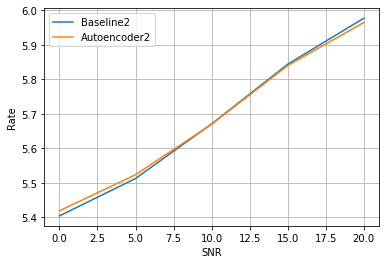

In [32]:
SNRs_eval = np.linspace(0, 20, 5)
rate_autoencoder2 = evaluate_rate(autoencoder2, SNRs_eval)
rate_baseline2 = evaluate_rate(baseline2, SNRs_eval)

plt.plot(SNRs_eval, rate_baseline2, label='Baseline2')
plt.plot(SNRs_eval, rate_autoencoder2, label='Autoencoder2')
plt.xlabel('SNR')
plt.ylabel('Rate')
plt.legend()
plt.grid()

We can also visualize the sent constellation at different SNRs : 

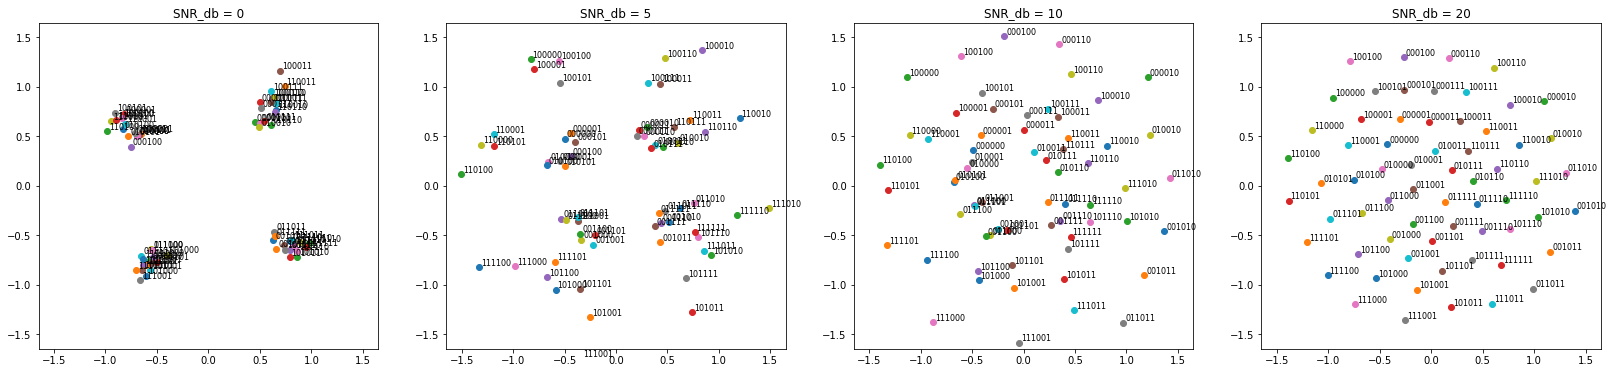

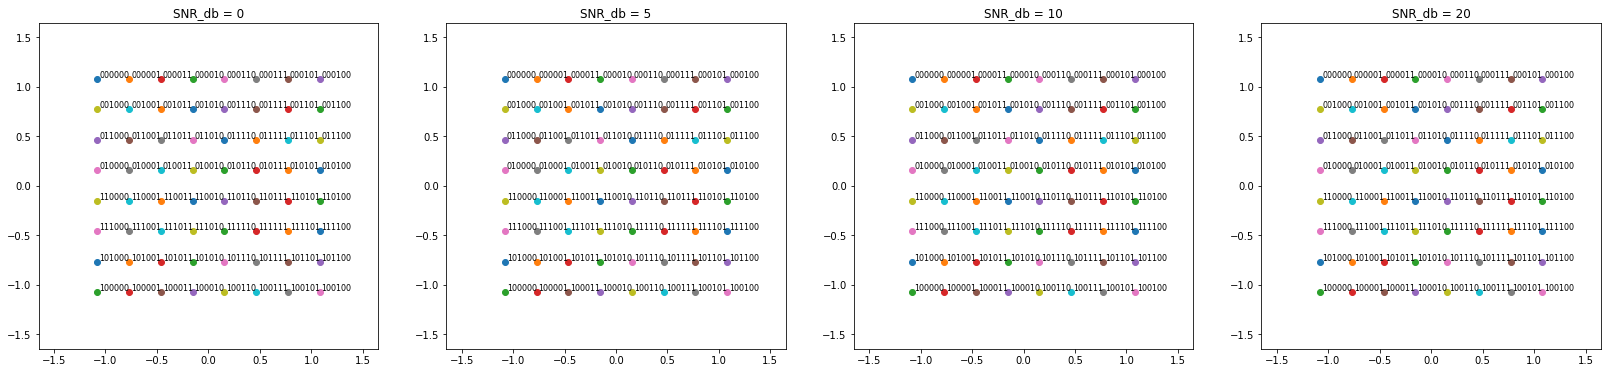

In [33]:
visualize(autoencoder2, SNRs_db=[0, 5, 10, 20])
visualize(baseline2, SNRs_db=[0, 5, 10, 20])

# 3 - Transmit on multiple channel uses

One vector of $K$ bits can also be transmitted on multiple channel uses, meaning that for each vector of $K$ bits in the batch we send $N_c$ complex symbols instead of $1$. $N_c$ denotes the number of channel uses, and the symbols sent that correspond to one vector of bits are denoted $\mathbf{x}\in \mathbb{C}^{N_c}$

The goal here is to transmit $N_c$ symbols for each entry in the batch, making sure that the average power per symbol remains one : $\mathbb{E}[[x|] =1$.

### 3.0 - Example with the baseline, with $N_c=2$

In [34]:
K=6
Nc = 2

DS_size=100 
DS_bits, DS_SNRs_db = gen_DS(DS_size, K, SNR_db_low=-5, SNR_db_high=30) #Generate a dataset

# Initialize the baseline
baseline3 = Model_QAM(K, Nc)

# Define a very small batch containing just one sample to visualize the output
batch_bits = DS_bits[:1]
batch_SNRs = DS_SNRs_db[:1]

# Print the sent bits
print('batch_bits : ', batch_bits)
print('batch_SNRs : ', batch_SNRs)

# Compute probabilities that the bits equals to one
prob_eq_1 = baseline3(batch_bits, batch_SNRs)

# Print the symbols that were sent
print('baseline.x : ', baseline3.x) # x is now a vector of size Nc !

# Print the predicted probabilities
print('pb predicted by the baseline : ', prob_eq_1)

batch_bits :  tf.Tensor([[1. 1. 1. 0. 1. 1.]], shape=(1, 6), dtype=float32)
batch_SNRs :  tf.Tensor([[-1.899445]], shape=(1, 1), dtype=float32)
baseline.x :  tf.Tensor([[-0.46291006-0.46291006j -0.46291006-0.46291006j]], shape=(1, 2), dtype=complex64)
pb predicted by the baseline :  tf.Tensor([[0.56740177 0.611499   0.5158743  0.34670994 0.58784187 0.5151516 ]], shape=(1, 6), dtype=float32)


You can visualize the $N_c$ channel uses with the `visualize_channel_uses()` function

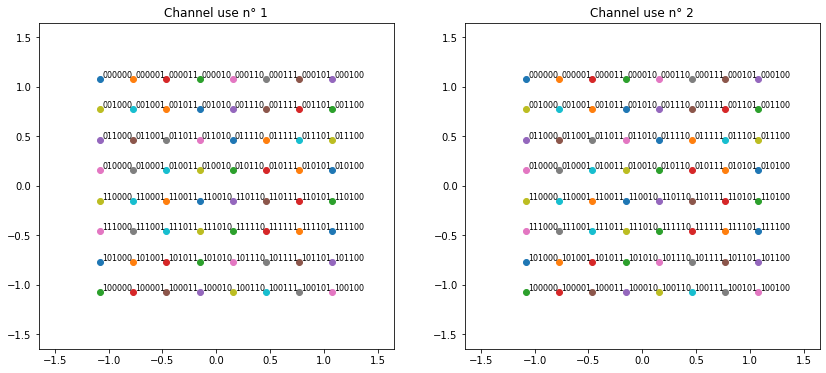

In [35]:
visualize_channel_uses(baseline3, SNR_db = 10)

### 3.1 - Build the autoencoder, train, and evaluate

In [36]:
import sys
class Autoencoder3(Model):

    def __init__(self, K, Nc, **kwargs):
        super(Autoencoder3, self).__init__(**kwargs)
        
        self.K = K
        self.Nc = Nc
        self.powtwo = tf.constant([float(tf.pow(2, i)) for i in range(self.K)])
        
        self.tx_layer_1 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_2 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_3 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_4 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_5 = Dense(512, activation='relu') ### Define transmitter layers
        self.tx_layer_6 = Dense(self.Nc * 2 * tf.pow(2, K)) ### Define transmitter layers
        
        self.channel = Channel(self.Nc) 
        
        self.rx_layer_1 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_2 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_3 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_4 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_5 = Dense(512, activation='relu') ### Define receiver layers
        self.rx_layer_6 = Dense(self.K, activation='sigmoid') ### Define receiver layers
    
    def call(self, bits, SNR_db):        
        ### Emitter
        self.x = SNR_db
        self.x = self.tx_layer_1(self.x)
        self.x = self.tx_layer_2(self.x)
        self.x = self.tx_layer_3(self.x)
        self.x = self.tx_layer_4(self.x)
        self.x = self.tx_layer_5(self.x)
        self.x = self.tx_layer_6(self.x)
        self.x = tf.reshape(self.x, [self.x.shape[0], self.Nc, 2 * tf.pow(2, K)])
        self.x = tf.complex(self.x[:,:,:(tf.pow(2,K))], self.x[:,:,(tf.pow(2,K)):])       

        ### Normalization & Channel
        bit = tf.math.reduce_sum(bits * self.powtwo, 1)
        bit = tf.reshape(bit, [bit.shape[0], 1])
        bit = tf.repeat(bit, self.Nc, 1)
        bit = tf.cast(bit, tf.int32)
        bit = tf.one_hot(bit, tf.pow(2, K))

        self.energy = tf.reduce_mean(tf.square(tf.abs(self.x)), axis=2, keepdims=True)
        self.x = self.x/tf.cast(tf.sqrt(self.energy),tf.complex64)
        self.x = tf.reduce_sum(tf.math.multiply(self.x, tf.cast(bit,tf.complex64)), axis=2, keepdims=True)
        self.y = self.channel(tf.squeeze(self.x), SNR_db)
        self.y = tf.concat([tf.math.real(self.y), tf.math.imag(self.y)], axis=1)

        ### Receiver
        self.y = tf.concat([SNR_db, self.y], axis=1)
        self.y = self.rx_layer_1(self.y)
        self.y = self.rx_layer_2(self.y)
        self.y = self.rx_layer_3(self.y)
        self.y = self.rx_layer_4(self.y)
        self.y = self.rx_layer_5(self.y)
        self.pb = self.rx_layer_6(self.y)
        
        return self.pb

In [37]:
K = 6
Nc = 2

# Instantiate an autoencoder
autoencoder3 = Autoencoder3(K, Nc)
baseline3 = Model_QAM(K, Nc)

#Initialize optimizer and loss function
optimizer = tf.keras.optimizers.Adam() # Optimizer
loss_func = tf.keras.losses.BinaryCrossentropy() # Loss function

In [38]:
DS_size_train = 100000
DS_size_test = 1000

batch_size = 1024
DS_bits, DS_SNRs_db = gen_DS(DS_size_train+DS_size_test, K, SNR_db_low=-5, SNR_db_high=30)
print('Dataset generated with K =', K)
TF_DS_train = tf.data.Dataset.from_tensor_slices((DS_bits[:DS_size_train], DS_SNRs_db[:DS_size_train])).shuffle(10000).batch(batch_size)
TF_DS_test = tf.data.Dataset.from_tensor_slices((DS_bits[DS_size_train:], DS_SNRs_db[DS_size_train:])).batch(batch_size)

Dataset generated with K = 6


In [39]:
### Training loop
nb_epoch = 50

print('Loss after each epoch:')

for epoch in range(nb_epoch):
    
    # Iterate over the batches of the dataset.
    for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_train):
        
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            probas = autoencoder3(DS_bits, DS_SNRs_db)

            # Loss value for this batch.
            loss_value = loss_func(y_true=DS_bits, y_pred=probas)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder3.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder3.trainable_weights))
    
    #Test the model on the test datasets
    test_loss = 0.
    for step, (DS_bits, DS_SNRs_db) in enumerate(TF_DS_test):
        probas = autoencoder3(DS_bits, DS_SNRs_db)
        test_loss += loss_func(y_true=DS_bits, y_pred=probas)
    print((test_loss/(step+1)).numpy(), end=', ')
print('Done')

Loss after each epoch:
0.19493628, 0.16417201, 0.15774703, 0.15756683, 0.16198967, 0.15462773, 0.15468374, 0.16008809, 0.1611128, 0.15311186, 0.15675387, 0.15789165, 0.16063501, 0.1608623, 0.1593586, 0.15304282, 0.15520819, 0.14807256, 0.15565652, 0.16137636, 0.15537584, 0.15187909, 0.15411167, 0.15680611, 0.15677017, 0.1580255, 0.15875554, 0.1476611, 0.15508994, 0.15197726, 0.15422983, 0.1497103, 0.15311238, 0.15724513, 0.15608983, 0.15519229, 0.15452011, 0.14944044, 0.15678705, 0.15402313, 0.15212128, 0.15689209, 0.1594588, 0.15607117, 0.1631722, 0.15434276, 0.15432443, 0.15425238, 0.15132754, 0.14841695, Done


K = 6
SNR (dB) = 0.0, 5.0, 10.0, 15.0, 20.0, 
K = 6
SNR (dB) = 0.0, 5.0, 10.0, 15.0, 20.0, 


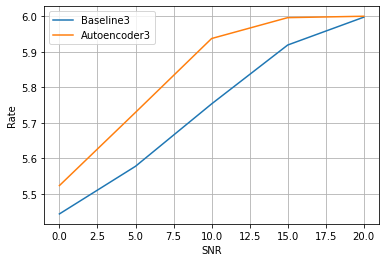

In [40]:
SNRs_eval = np.linspace(0, 20, 5)
rate_autoencoder3 = evaluate_rate(autoencoder3, SNRs_eval)
rate_baseline3 = evaluate_rate(baseline3, SNRs_eval)

plt.plot(SNRs_eval, rate_baseline3, label='Baseline3')
plt.plot(SNRs_eval, rate_autoencoder3, label='Autoencoder3')
plt.xlabel('SNR')
plt.ylabel('Rate')
plt.legend()
plt.grid()

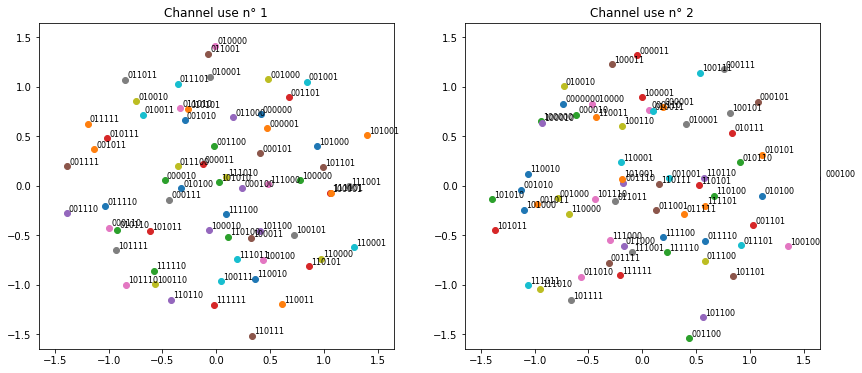

In [41]:
visualize_channel_uses(autoencoder3, SNR_db = 10)

Can you see something interesting?